### Intro

Beta Bank is experiencing a gradual customer attrition, with clients leaving the bank every month. To address this, the bank wants to retain existing customers, as it is more cost-effective than acquiring new ones. The goal is to develop a predictive model that can accurately identify customers who are likely to leave in the near future, which would enable the bank to take proactive retention measures.

Using historical data on customer behavior and contract terminations, I will train a model to maximize the F1 score, focusing on balancing precision and recall. To meet the project requirements, the model must achieve an F1 score of at least 0.59 on the test set. I will also calculate the AUC-ROC metric to assess model performance, comparing it with the F1 score to ensure the model effectively distinguishes between those likely to stay and those at risk of leaving.

#### Import libraries

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.utils import shuffle
from imblearn.pipeline import Pipeline as ImbPipeline 
import matplotlib.pyplot as plt
import seaborn as sns

#### Load data

In [12]:
df= pd.read_csv('Churn.csv')
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


(10000, 14)

In [13]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1




It's almost always not a good idea to drop NaNs when you work with ML models. When you drop a row becasue of NaN in one column you lose information from other columns which can be useful for model traning. So, instead of to drop NaNs it's better to fill them.


In [14]:
## Identify and fill in missing values

## Step 1: check for outliers
df.describe()['Tenure']

## Looking at describe method there are no outliers. There are no values greater than max or lower than min.

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


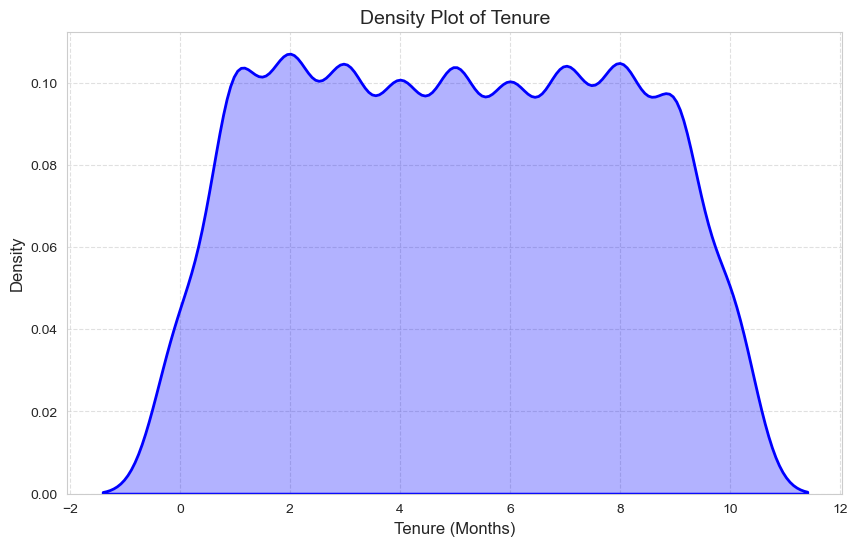

In [16]:
## Step 2: Look at histogram


sns.set_style("whitegrid")

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot KDE (smooth density curve)
sns.kdeplot(df['Tenure'], color="blue", linewidth=2, fill=True, alpha=0.3, ax=ax)

# Add labels and title
ax.set_title("Density Plot of Tenure", fontsize=14)
ax.set_xlabel("Tenure (Months)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)

# Add grid for readability
ax.grid(True, linestyle="--", alpha=0.6)


plt.show()

# The plot does not indicate any outliers.


In [17]:
## Step 3:  No clear outliers, so I will use mean to fill missing values in the Tenure column

avg_tenure= df['Tenure'].mean()
print("Mean:", avg_tenure)

df['Tenure'] = df['Tenure'].fillna(avg_tenure)

Mean: 4.997690023099769


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Feature Selection and Encoding 

In [19]:
# Separate features and target
target = df['Exited']
features = df.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

In [20]:
# Identify categorical and numerical columns
categorical_features = ['Geography', 'Gender']
numerical_features = features.drop(columns=categorical_features).columns


In [21]:
# Preprocessing pipeline for numerical features
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first')  # drop='first' to avoid dummy variable trap

# Bundle preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

### Train model ignoring class imbalance


In [22]:
print(df['Exited'].value_counts(normalize=True))

## The classes are unbalanced 

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


#### Logistic Regression

In [23]:
# Split into training and keep the remaining set (60%: 40%)
X_train, X_remaining, y_train, y_remaining  = train_test_split(features, target,
            test_size=0.4, random_state=12345) # 40% of the entire dataset is set aside as a remaining set

# Split into validation and test sets (60%: 40%)
X_val, X_test, y_val, y_test = train_test_split(
     X_remaining, y_remaining, test_size=0.5, random_state=12345) # validation set=20% of remaining set and test set=20%



In [24]:
# Combine preprocessing and model into a pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', LogisticRegression(random_state=42))])

In [25]:
# Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('model', LogisticRegression(random_state=42))])

In [26]:
# Make predictions
predictions = model_pipeline.predict(X_val)

# Evaluate the model
f1 = f1_score(y_val, predictions)
roc_auc = roc_auc_score(y_val, model_pipeline.predict_proba(X_val)[:, 1])

print(f'F1 Score: {f1}')

F1 Score: 0.3316412859560068


In [27]:
print(f'ROC-AUC Score: {roc_auc}')
print(classification_report(y_val, predictions))

ROC-AUC Score: 0.7587074081019121
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1582
           1       0.57      0.23      0.33       418

    accuracy                           0.80      2000
   macro avg       0.70      0.59      0.61      2000
weighted avg       0.77      0.80      0.77      2000



##### Summary:
The results indicate that the imbalanced model performs well in distinguishing between the two classes overall, as evidenced by the ROC-AUC score of 0.76. However, the F1 score for the minority class (class 1) is low at 0.33, which suggests that the model struggles with capturing instances of this class effectively.

### Training models and fixing class imbalance

#### Random Forest with class weight balanced 

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 7479 to 4578
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      6000 non-null   int64  
 1   Geography        6000 non-null   object 
 2   Gender           6000 non-null   object 
 3   Age              6000 non-null   int64  
 4   Tenure           6000 non-null   float64
 5   Balance          6000 non-null   float64
 6   NumOfProducts    6000 non-null   int64  
 7   HasCrCard        6000 non-null   int64  
 8   IsActiveMember   6000 non-null   int64  
 9   EstimatedSalary  6000 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 515.6+ KB


In [29]:
#### Hyperparameter tuning

# Set up hyperparameter grid for the RandomForestClassifier
param_grid = {
    'model__max_depth': range(1, 10),
    'model__n_estimators': range(10, 100, 10)
}

# Initialize preprocessor and model within a pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', RandomForestClassifier(random_state=12345, class_weight='balanced'))])

# Use GridSearchCV to tune the hyperparameters within the pipeline (using F1 score as the primary metric)
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:", grid_search.best_params_)


Best parameters found by GridSearchCV: {'model__max_depth': 9, 'model__n_estimators': 90}


In [30]:
#### Best model and threshold tuning

# Extract the best model from GridSearchCV
best_modelRF = grid_search.best_estimator_

# Get predicted probabilities for the validation set
probabilities_valid = best_modelRF.predict_proba(X_val)[:, 1]

# Calculate the AUC-ROC score for the validation set
auc_roc = roc_auc_score(y_val, probabilities_valid)
print("AUC-ROC on validation set:", auc_roc)

# Tune threshold for the F1 score on validation set
best_threshold = 0.5
best_F1score_RF = 0

for threshold in np.arange(0, 0.9, 0.02):
    predicted_valid = probabilities_valid > threshold
    F1_score = f1_score(y_val, predicted_valid)
    
    if F1_score > best_F1score_RF:
        best_threshold = threshold
        best_F1score_RF = F1_score

print("Best threshold:", best_threshold)
print("Best F1 score on validation set:", best_F1score_RF)




AUC-ROC on validation set: 0.8545282151476841
Best threshold: 0.48
Best F1 score on validation set: 0.6278814489571899


##### Summary:

The model was trained with balanced class weights to handle class imbalance effectively. On the validation set, the model achieved an AUC-ROC of 0.85, indicating strong discrimination between classes. Additionally, tuning for the optimal F1 score yielded a best score of 0.63, balancing precision and recall for this dataset.



#### Decision Tree classifier with oversmapling

In [31]:

# Pipeline with RandomOverSampler from imbalanced-learn
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('oversampler', RandomOverSampler(random_state=12345)),  # Apply oversampling only to training set
    ('model', DecisionTreeClassifier(random_state=12345))    
])

# Define hyperparameter grid for DecisionTreeClassifier
param_grid = {
    'model__max_depth': range(1, 10),
    'model__min_samples_split': range(2, 10)
}

# Use GridSearchCV to tune the hyperparameters within the pipeline
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Extract the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Get probabilities for the validation set
probabilities_valid = best_model.predict_proba(X_val)[:, 1]

# Calculate the AUC-ROC score for the validation set
auc_roc = roc_auc_score(y_val, probabilities_valid)
print("AUC-ROC on validation set:", auc_roc)

# Tune threshold on validation set for the best F1 score
best_threshold = 0.5
best_F1score = 0

for threshold in np.arange(0, 0.9, 0.02):
    predicted_valid = probabilities_valid > threshold
    F1_score = f1_score(y_val, predicted_valid)
    
    if F1_score > best_F1score:
        best_threshold = threshold
        best_F1score = F1_score


Best parameters found by GridSearchCV: {'model__max_depth': 7, 'model__min_samples_split': 7}
AUC-ROC on validation set: 0.8037506275745679


In [32]:
# Print summary of the best model, hyperparameters, and threshold
print("Final trained Decision Tree model:", best_model)
print("Best hyperparameters:", grid_search.best_params_)
print("AUC-ROC on validation set:", auc_roc)
print("Best threshold for F1 score:", best_threshold)
print("Best F1 score on validation set:", best_F1score)

Final trained Decision Tree model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('oversampler', RandomOverSampler(random_state=12345)),
                ('model',
                 DecisionTreeClassifier(max_depth=7, min_samples_split=7,
                                        random_state=12345))])
Best hyperparameters: {'model__max_depth': 7, 'model__min_samples_split': 7}
AUC-ROC on validation set: 0.8037506275745679
Best threshold for F1 score: 0.78
Best F1 score on validation set: 0.5868945868945868

##### Summary:
The model was trained with balanced class weights to address class imbalance. On the validation set, the model achieved an AUC-ROC of 0.80, indicating a good level of class separation. Further tuning for the optimal F1 score led to a best score of 0.568 at a threshold of 0.78, balancing precision and recall effectively for this dataset.

#### Light GBM with SMOTE

In [33]:
#pip install lightgbm

In [34]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score
from lightgbm import LGBMClassifier


# Separate features and target
target = df['Exited']
features = df.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

# Identify categorical and numerical columns
categorical_features = ['Geography', 'Gender']
numerical_features = features.drop(columns=categorical_features).columns

# Preprocessing pipeline for numerical features
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first')

# Bundle preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(
        boosting_type='gbdt',
        objective='binary',
        metric='auc',
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=42
    ))
])

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Train the model pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
y_val_pred = pipeline.predict(X_val)  # Get binary predictions

# Calculate ROC AUC and F1 score
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)
f1_val = f1_score(y_val, y_val_pred)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 4773, number of negative: 4773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightG

In [35]:
print(f'Validation ROC AUC score: {roc_auc_val}')
print(f'Validation F1 score: {f1_val}')

Validation ROC AUC score: 0.8496393762183236
Validation F1 score: 0.5859697386519945


##### Summary:
The model was trained with SMOTE to address class imbalance. On the validation set, the model achieved an AUC-ROC of 0.849, indicating a good level of class separation. Further tuning for the optimal F1 score led to a best score of 0.585, balancing precision and recall effectively for this dataset.

### Testing-Random Forest model

In [36]:
# Apply the best model to the test set
probabilities_test = best_modelRF.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC on the test set
auc_roc_test = roc_auc_score(y_test, probabilities_test)
print("AUC-ROC on test set:", auc_roc_test)

# Make predictions on the test set using the best threshold found from the validation set
predicted_test = probabilities_test > best_threshold

# Calculate F1 score on the test set
F1_score_test = f1_score(y_test, predicted_test)
print("F1 score on test set:", F1_score_test)

# Print summary of test performance
print("Final model test performance summary:")
print("AUC-ROC on test set:", auc_roc_test)
print("F1 score on test set using threshold", best_threshold, ":", F1_score_test)


AUC-ROC on test set: 0.9156362020441418
F1 score on test set: 0.53156146179402
Final model test performance summary:
AUC-ROC on test set: 0.9156362020441418
F1 score on test set using threshold 0.78 : 0.53156146179402


##### Summary:

The Random Forest model achieved an AUC-ROC score of 0.91 on the test set, indicating good overall discrimination between classes. However, the F1 score on the test set was relatively low at 0.53, suggesting that while the model distinguishes between classes well, it struggles with accurately balancing precision and recall in its predictions for the positive class

### Testing-Decision Tree model

In [37]:
# Apply the best model to the test set
probabilities_test = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC on the test set
auc_roc_test = roc_auc_score(y_test, probabilities_test)
print("AUC-ROC on test set:", auc_roc_test)

# Make predictions on the test set using the best threshold found from the validation set
predicted_test = probabilities_test > best_threshold

# Calculate F1 score on the test set
F1_score_test = f1_score(y_test, predicted_test)
print("F1 score on test set:", F1_score_test)

# Print summary of test performance
print("Final model test performance summary:")
print("AUC-ROC on test set:", auc_roc_test)
print("F1 score on test set using threshold", best_threshold, ":", F1_score_test)


AUC-ROC on test set: 0.8512242630721375
F1 score on test set: 0.6187845303867403
Final model test performance summary:
AUC-ROC on test set: 0.8512242630721375
F1 score on test set using threshold 0.78 : 0.6187845303867403


##### Summary

The Decision Tree model achieved an AUC-ROC score of 0.85 on the test set, suggetsing a moderate ability to distinguish between classes. The F1 score was 0.62, reflecting a balance between precision and recall. This suggests that the model performs reasonably well in identifying the positive class, though there may still be room for improvement in overall classification accuracy and balance between sensitivity and specificity.

### Testing light GBM model

In [38]:
# Predict on the test set
y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
y_test_pred = pipeline.predict(X_test)  # Get binary predictions

# Calculate ROC AUC and F1 score on the test set
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
f1_test = f1_score(y_test, y_test_pred)

print(f'Test ROC AUC score: {roc_auc_test}')
print(f'Test F1 score: {f1_test}')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Test ROC AUC score: 0.8662227818101021
Test F1 score: 0.6450809464508095


##### Summary

The light GBM model achieved an AUC-ROC score of 0.87 on the test set, suggetsing a moderate ability to distinguish between classes. The F1 score was 0.65, reflecting a balance between precision and recall. This suggests that the model performs reasonably well in identifying the positive class.

### Conclusion

The Light GBM model achevied the best F1 score=0.65 and AUC ROC score=0.87.